In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
%cd /content/drive/MyDrive/UOPJ

/content/drive/MyDrive/UOPJ


In [3]:
sections = ["culture", "future", "travel", "worklife"]

On the website https://www.bbc.com/ there is news arranged in sections. We chose four sections (culture, future, travel, worklife) and extracted the texts of the articles from them. In the end, we wanted to train the Naive Bayes classifier to recognize which section a given sentence belongs to.

If you have the necessary datasets, it is not necessary to run the data collection part. Only the functions for data processing, creation and evaluation of data need to be run.

# Imports

In [27]:
# Data collection
import requests
from bs4 import BeautifulSoup
import os

# Data processing
import nltk
import nltk.data
nltk.download("punkt")
from nltk.corpus import stopwords
nltk.download('stopwords')
import re
from nltk.stem.porter import PorterStemmer

# Descriptive statistics
import numpy as np
import matplotlib.pyplot as plt

# Creating model and evaluation
import csv
import pandas as pd

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Functions

## Data collection

The **Get_urls** function receives one url as a parameter. It is the homepage url. It then searches the page and finds all the links that are on that home page. Finally, it returns a list of all the links it found.

In [ ]:
def Get_urls(url):
    reqs = requests.get(url)
    soup = BeautifulSoup(reqs.text, "html.parser")
    
    urls = []
    for link in soup.find_all("a"):
        urls.append(link.get("href"))
    
    return urls

The **Get_links** function receives a list of urls and an identifier that shows us whether a url belongs to the section we need. In this case, if the url starts with "section + /article/" we know that this url should be saved, otherwise we delete it.

In [ ]:
def Get_links(urls, start):
    links = []
    for url in urls:
        if str(url).startswith(start):
            url1="https://www.bbc.com" + url
            if url1 not in links:
                links.append(url1)
    
    return links

The **Get_contents** function receives as a parameter the links we saved in the previous step. Each section has several subcategories, so it is necessary to say how many there are. The function returns a list of all paragraphs in the article, removing subcategory names.

In [ ]:
def Get_contents(links, start):
    contents = []
    for link in links:
        page = requests.get(str(link))
        soup = BeautifulSoup(page.content, "html.parser")
        
        content = []
        for el in soup.select("p"):
            content.append(el.text)
        
        contents.append(content[start:])
    
    return contents

The **Get_sentences** function receives a list of sentences and combines them into a single text. Finally, it returns a list of merged texts for each article in a certain section.

In [ ]:
def Get_sentences(contents):
    sentences = []
    for content in contents:
        raw_sents = ""
        for recenica in content:
            raw_sents += recenica
        
        sentences.append(raw_sents)
    
    return sentences

The **Save_to_txt** function receives a title to be assigned to the txt file and a list of sentences. For each element of the list, it creates a new txt file and saves the text of the article in it.

In [ ]:
def Save_to_txt(title, sentences):
    path = f"./{title}"
    if not os.path.exists(path):
        os.makedirs(path)
    
    for i in range(len(sentences)):
        with open(f"{path}/{i}.txt", "w") as f:
            f.write(sentences[i])

**Get_dataset** is the main function we call when collecting a data. As a parameter, it receives a section and the number of subcategories for that section. It calls all the above functions.

In [ ]:
def Get_data(section, excess):
    urls = Get_urls("https://www.bbc.com/" + section)
    links = Get_links(urls, "/" + section + "/article/")
    contents = Get_contents(links, excess)
    sentences = Get_sentences(contents)
    Save_to_txt(section, sentences)

## Data processing

The **Text_to_sentences** function receives text as a parameter and breaks it down into a list of sentences.

In [4]:
def Text_to_sentences(text):
    tokenizer = nltk.data.load("tokenizers/punkt/english.pickle")
    
    return tokenizer.tokenize(text)

**Get_lowercase_text** is a simple function that takes text as a parameter and transforms it into lowercase text.

In [5]:
def Get_lowercase_text(text):
    return text.lower()

The **Remove_useless_symbols** function receives text as a parameter. It removes all punctuation marks and all other non-letter symbols from it.

In [6]:
def Remove_useless_symbols(text):
    return re.sub(r"¸|\+|<|>|,|\.|-|¨|!|\"|#|\$|%|&|\/|\(|\)|=|\?|\*|;|:|_|~|ˇ|\^|˘|°|˛|`|˙|´|˝|\\|\||€|÷|×|\[|\]|ł|Ł|ß|¤|@|{|}|§", "", text)

The **Stem** function receives a sentence as a parameter. It goes through that sentence and keeps only the stem of the word.

In [7]:
def Stem(sentence):
    stemmer = PorterStemmer()
    
    return " ".join(stemmer.stem(word) for word in sentence.split())

The **Remove_stopwords** function receives a sentence as a parameter. It compares each word in the sentence with the list of stopwords for the language we use (English) and keeps only those words that are not on that list.

In [8]:
def Remove_stopwords(text):
    sw = stopwords.words("english")
    
    return " ".join([word for word in text.split() if word not in (sw)])

The **Data_processing** function is the main function. As a parameter, it receives text and two bool values, one of which tells whether the normalization of the text will be done, and the other which tells whether stopwords will be removed from the text.
The function first divides the text into sentences. If normalization is done, the functions Get_lowercase_text, Remove_useless_symbols and Stem are called in order. If it is necessary to remove stopwords from the text, the Remove_stopwords function will be called.
At the end, the function returns a list of sentences modified according to the appropriate requirements.

In [9]:
def Data_processing(text, stopwrds, norm):
    sentences = Text_to_sentences(text)
    
    if norm:
        sentences = [Get_lowercase_text(sent) for sent in sentences]
        sentences = [Remove_useless_symbols(sent) for sent in sentences]
        sentences = [Stem(sent) for sent in sentences]
    
    if stopwrds:
        sentences = [Remove_stopwords(sent) for sent in sentences]
    
    return sentences

The **Processing_folder** function creates a new folder for each section. In that folder, it creates a txt file for each article and saves the modified text of the article in it.

In [10]:
def Processing_folder(section, stopwrds, norm):
    folder = f"./{section}"
    for file in os.listdir(folder):
        with open(os.path.join(folder, file), "r") as f:
            text = f.read()
        
        sentences = Data_processing(text, stopwrds, norm)
        
        path = f"./{section}_processed"
        if not os.path.exists(path):
            os.makedirs(path)
        
        with open(f"{path}/{file[:-4]}_processed.txt", "w") as f:
            for sentence in sentences:
                f.write(f"{sentence}\n")

## Descriptive statistics

The **Read** function receives one of four sections as a parameter. For each modified article (txt file inside the processed folder) it retrieves the number of occurrences. In addition, it also creates a list of all occurrences (one list that includes occurrences from all articles / txt files)

In [11]:
def Read(section):
    websites = dict()
    occurrences = list()

    folder = f"./{section}_processed"
    for file in os.listdir(folder):
        with open(os.path.join(folder, file), "r") as f:
            text = f.read()

        word_counter = len(set(text.split()))
        websites[file] = word_counter
        occurrences.extend(text.split())
    
    return websites, occurrences

The **Occurrences_by_files** function receives a dictionary as a parameter. It contains the names of the txt files and the corresponding number of occurrences for each file. The function prints out all files and occurrence numbers and displays this data on the plot.

In [12]:
def Occurrences_by_files(websites):
    print("Number of occurrences at the file level \n")
    
    occurrences_counter = list(websites.values())

    keys = sorted(websites.keys())
    for key in keys:
        print(key, ": ", websites[key])
    print()

    plt.hist(occurrences_counter)
    plt.show()

    return occurrences_counter

The **Statistics_by_file** function receives as a parameter a list containing the occurrence numbers of all files. Prints the minimum and maximum number of occurrences and the standard deviation, mean and median.

In [13]:
def Statistics_by_file(occurrences_counter, websites):
    print("Statistics at the file level \n")

    mn = min(occurrences_counter)
    print("Minimum: ", mn, " - ", list(websites.keys())[list(websites.values()).index(mn)])

    mx = max(occurrences_counter)
    print("Maximum: ", mx, " - ", list(websites.keys())[list(websites.values()).index(mx)])

    print("Standard deviation: ", round(np.std(occurrences_counter), 2))
    print("Mean: ", round(np.mean(occurrences_counter), 2))
    print("Median: ", round(np.median(occurrences_counter), 2))

The **Statistics_by_occurrences** function receives a list of all occurrences (occurrences from all txt files) as a parameter. Prints the minimum and maximum number of occurrences of a given occurrence, standard deviation, mean and median.

In [14]:
def Statistics_by_occurrences(occurrences):
    print("Statistics at the occurrences level \n")
    occurrence_freq = dict()
    for occurrence in occurrences:
        occurrence_freq[occurrence] = occurrence_freq.get(occurrence, 0) + 1
    
    occurrence_freq = sorted(list(occurrence_freq.items()), key=lambda x : x[1])
    occurrence_freq_values = [fp[1] for fp in occurrence_freq]

    print("Minimum: ", min(occurrence_freq_values))
    print("Maximum: ", max(occurrence_freq_values))
    print("Standard deviation: ", round(np.std(occurrence_freq_values), 2))
    print("Mean: ", round(np.mean(occurrence_freq_values), 2))
    print("Median: ", round(np.median(occurrence_freq_values), 2))

    return occurrence_freq

The function **Most_frequently** receives a dictionary of occurrence frequencies as a parameter. It contains occurrences as keys and the corresponding number of total occurrences in all txt files. It prints the ten occurrences that appear the most number of times.

In [15]:
def Most_frequent(occurrence_freq):
    print("Ten most frequent occurrences \n")

    mf = occurrence_freq[-10:]
    for i in range(len(mf)-1, -1, -1):
        print(mf[i][0], ": ", mf[i][1])

The function **Least_frequent** receives a dictionary of occurrence frequencies as a parameter. It contains occurrences as keys and the corresponding number of total occurrences in all txt files. It prints the ten occurrences that appear the least number of times.

In [16]:
def Least_frequent(occurrence_freq):
    print("Ten least frequent occurrences \n")

    lf = occurrence_freq[:10]
    for occurrence in lf:
        print(occurrence[0], ": ", occurrence[1])

## Creating model and evaluation

The function **Make_csv** receives as a parameter the title to be assigned to the CSV file. It creates a CSV file and saves the text of the articles in it. Each line of the file contains two pieces of data. The first is the name of the section, and the second is the modified text of the article (txt file inside the processed folder). <br>
**It is not necessary to run this part if you want to use a dataset we already have, because this step will overwrite the existing one.**

In [17]:
def Make_csv(title):
    path = f"./datasets"
    if not os.path.exists(path):
        os.makedirs(path)
    
    header = ["section", "text"]
    with open(os.path.join(path, title), "w", encoding="UTF8", newline="") as c:
        writer = csv.writer(c)
        writer.writerow(header)
        for section in sections:
            folder = f"./{section}_processed"
            for file in os.listdir(folder):
                with open(os.path.join(folder, file), "r") as f:
                    text = f.read()
                row = [section, text]
                writer.writerow(row)

Creating our train_test_split function. <br>
It splits dataset into random train and test subsets.

In [18]:
def My_train_test_split(X, y, test_size, random_state):
    np.random.seed(random_state)
    mask = np.random.rand(len(X)) < test_size
    X_train = X[mask]
    y_train = y[mask]
    X_test = X[~mask]
    y_test = y[~mask]
    return X_train, X_test, y_train, y_test

Creating our CountVectorizer function. <br>
It converts a collection of text documents to a matrix of token counts.

In [19]:
def CountVectorize_fit(X):
    uniques = set()
    for i in range(len(X)):
        uniques |= set(np.unique(X[i].split()))
    D = dict()
    vocab_size = len(list(uniques))
    for i, word in enumerate(list(uniques)):
        D[word] = i
    Xv= []
    for i in range(len(X)):
        xv = np.zeros(shape = (vocab_size))
        for word in X[i].split():
            xv[D[word]] += 1
        Xv.append(xv)
    return np.array(Xv), D

def CountVectorize_get(X, D):
    Xv= []
    for i in range(len(X)):
        xv = np.zeros(shape = (len(D)))
        for word in X[i].split():
            if word in D:
                xv[D[word]] += 1
        Xv.append(xv)
    return np.array(Xv)

Creating our confusion matrix.

In [20]:
def My_confusion_matrix(y_true, y_predicted):
    matrix = []
    for i, label_true in enumerate(y_true.unique()):
        matrix.append([])
        for label_pred in y_true.unique():
            cnt = 0
            for l in range(len(y_true)):
                if y_true[l] == label_true and y_predicted[l] == label_pred:
                    cnt += 1
            
            matrix[i].append(cnt)
    return np.array(matrix)

From the confusion matrix, true positive (TP), true negative (TN), false positive (FP) and false negative (FN) values for each class are calculated. True positive (TP) is an outcome where the model correctly predicts the positive class. True Negative (TN) is an outcome where the model correctly predicts the negative class. False Positive (FP) is an outcome where the model incorrectly predicts the positive class. False Negative (FN) is an outcome where the model incorrectly predicts the negative class.

In [21]:
def Get_true_false_values(matrix):
    TP, FP, TN, FN = [], [], [], []
    for i in range(len(sections)):
        tp, fp, tn, fn = 0, 0, 0, 0

        for r in range(len(sections)):
            for c in range(len(sections)):
                if r == c and r == i:
                    tp = matrix[r][c]
                elif c == i and r != i:
                    fp += matrix[r][c]
                elif r == i and c != i:
                    fn += matrix[r][c]
                else:
                    tn += matrix[r][c]
        
        TP.append(tp)
        FP.append(fp)
        TN.append(tn)
        FN.append(fn)
    
    return TP, FP, TN, FN

Precision, recall and f1 score are calculated for each class separately. <br>
The precision (P) is basically defined as the ratio of correctly predicted positive classes to all predicted positive classes. It can be expressed mathematically as: $P=\frac{TP}{TP + FP}$. <br>
The recall (R) is simply defined as a ratio of correctly predicted positive classes to all actually existing positive classes. It can be expressed mathematically as: $R=\frac{TP}{TP + FN}$. <br>
Combining precision and recall into a single metric is known as the f1-score. It's simply $f1=\frac{P \times R}{P + R}$.

In [22]:
def Get_precission_recall_f1(TP, FP, FN):
    P, R, F1 = [], [], []
    for i in range(len(sections)):
        p = TP[i] / (TP[i] + FP[i])
        r = TP[i] / (TP[i] + FN[i])
        f1 = 2 * ((p * r) / (p + r))

        P.append(p)
        R.append(r)
        F1.append(f1)

        print(sections[i])
        print("Precision: ", round(p * 100, 2))
        print("Recall: ", round(r * 100, 2))
        print("F1 score: ", round(f1 * 100, 2))
        print()
    
    return P, R, F1

Macro precision, micro precision, macro recall, micro recall, macro f1-score, micro f1-score are calculated for all classes. <br>
Macro-averaged metrics are used when we want to evaluate system performance across different classes. <br>
Micro-averaged metrics should be used when the size of classes are variable. <br>
In the case when we have four classes (A, B, C, D), the formulas for calculating these values are as follows: <br><br>
$$MaP = \frac{P_A + P_B + P_C + P_D}{4}$$ <br>
$$MiP = \frac{TP_A + TP_B + TP_C + TP_D}{TP_A + FP_A + TP_B + FP_B + TP_C + FP_C + TP_D + FP_D}$$ <br>
$$MaR = \frac{R_A + R_B + R_C + R_D}{4}$$ <br>
$$MiR = \frac{TP_A + TP_B + TP_C + TP_D}{TP_A + FN_A + TP_B + FN_B + TP_C + FN_C + TP_D + FN_D}$$ <br>
$$MaF1 = 2 \times \frac{MaP * MaR}{MaP + MaR}$$ <br>
$$MiF1 = 2 \times \frac{MiP * MiR}{MiP + MiR}$$

In [23]:
def Get_macro_micro_values(TP, FP, FN, P, R):
    MaP = (P[0] + P[1] + P[2] + P[3]) / 4
    MiP = (TP[0] + TP[1] + TP[2] + TP[3]) / (TP[0] + FP[0] + TP[1] + FP[1] + TP[2] + FP[2] + TP[3] + FP[3])
    
    MaR = (R[0] + R[1] + R[2] + R[3]) / 4
    MiR = (TP[0] + TP[1] + TP[2] + TP[3]) / (TP[0] + FN[0] + TP[1] + FN[1] + TP[2] + FN[2] + TP[3] + FN[3])
    
    MaF1 = 2 * ((MaP * MaR) / (MaP + MaR))
    MiF1 = 2 * ((MiP * MiR) / (MiP + MiR))
    
    print("Macro precision: ", round(MaP * 100, 2))
    print("Micro precision: ", round(MiP * 100, 2))
    
    print("Macro recall: ", round(MaR * 100, 2))
    print("Micro recall: ", round(MiR * 100, 2))
    
    print("Macro F1 score: ", round(MaF1 * 100, 2))
    print("Micro F1 score: ", round(MiF1 * 100, 2))

    return MaP, MiP, MaR, MiR, MaF1, MiF1

My multinomialNB classifier without sklearn

In [24]:
class MyMultinomialNB:
    def __init__(self, alpha=1):
        self.alpha = alpha 
    
    def fit(self, X_train, y_train):
        m, n = X_train.shape
        self._classes = np.unique(y_train)
        n_classes = len(self._classes)
        
        self._priors = np.zeros(n_classes)
        self._likelihoods = np.zeros((n_classes, n))
        
        for idx, c in enumerate(self._classes):
            X_train_c = X_train[c == y_train]
            self._priors[idx] = X_train_c.shape[0] / m 
            self._likelihoods[idx, :] = ((X_train_c.sum(axis=0)) + self.alpha) / (np.sum(X_train_c.sum(axis=0) + self.alpha))
    
    def predict(self, X_test):
        return [self._predict(x_test) for x_test in X_test]
    
    def _predict(self, x_test):
        posteriors = []
        for idx, c in enumerate(self._classes):
            prior_c = np.log(self._priors[idx])
            likelihoods_c = self.calc_likelihood(self._likelihoods[idx,:], x_test)
            posteriors_c = np.sum(likelihoods_c) + prior_c
            posteriors.append(posteriors_c)
        
        return self._classes[np.argmax(posteriors)]
    
    def calc_likelihood(self, cls_likeli, x_test):
        return np.log(cls_likeli) * x_test
    
    def score(self, X_test, y_test):
        y_pred = self.predict(X_test)
        
        return np.sum(y_pred == y_test)/len(y_test)

The **Make_model** function receives the dataset containing the data as a parameter. First, it reads that dataset, divides the data into a training set and a testing set, and creates a Naive Bayes classifier model.
Model evaluation is done using precision, recall and f1 score for each class. In addition, micro and macro precision, micro and macro recall and micro and macro f1 score values are also calculated.

In [25]:
def Make_model(dataset):
    path = f"./datasets"
    df = pd.read_csv(os.path.join(path, dataset))

    X_train, X_test, y_train, y_test = My_train_test_split(df.text, df.section, test_size=0.35, random_state=90)

    X_train_count, D = CountVectorize_fit(X_train.values)
    X_test_count = CountVectorize_get(X_test.values, D)


    model = MyMultinomialNB()
    model.fit(X_train_count, y_train)

    y_pred = model.predict(X_test_count)
    y_test = y_test.array

    acc = model.score(X_test_count, y_test)
    print("Model accuracy: ", round(acc * 100, 2))
    print()

    matrix = My_confusion_matrix(y_test, y_pred)
    print(matrix)
    print()
    
    TP, FP, TN, FN = Get_true_false_values(matrix)
    P, R, F1 = Get_precission_recall_f1(TP, FP, FN)
    MaP, MiP, MaR, MiR, MaF1, MiF1 = Get_macro_micro_values(TP, FP, FN, P, R)

# Data collection

The following code cell is used to call the data collection functions. <br>
**Don't run this part if you want to use a dataset we already have, because this step will overwrite the existing one.**

In [ ]:
excess = [12, 12, 11, 6]
for i in range(len(sections)):
    Get_data(sections[i], excess[i])

# No stopwords and no normalization

In [28]:
for section in sections:
    Processing_folder(section, False, False)

## Descriptive statistics

### Culture

In [29]:
websites, occurrences = Read("culture")

Number of occurrences at the file level 

0_processed.txt :  933
1_processed.txt :  1062
2_processed.txt :  1009
3_processed.txt :  501
4_processed.txt :  1036
5_processed.txt :  1010
6_processed.txt :  897
7_processed.txt :  952
8_processed.txt :  1074
9_processed.txt :  721



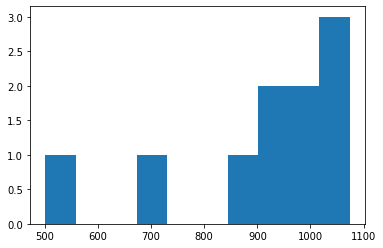

In [30]:
occurrences_counter = Occurrences_by_files(websites)

In [31]:
Statistics_by_file(occurrences_counter, websites)

Statistics at the file level 

Minimum:  501  -  3_processed.txt
Maximum:  1074  -  8_processed.txt
Standard deviation:  170.36
Mean:  919.5
Median:  980.5


In [32]:
occurrence_freq = Statistics_by_occurrences(occurrences)

Statistics at the occurrences level 

Minimum:  1
Maximum:  840
Standard deviation:  19.26
Mean:  3.0
Median:  1.0


In [33]:
Most_frequent(occurrence_freq)

Ten most frequent occurrences 

the :  840
of :  584
and :  545
a :  520
to :  428
in :  357
is :  202
that :  186
as :  172
for :  156


In [34]:
Least_frequent(occurrence_freq)

Ten least frequent occurrences 

"How :  1
lived, :  1
death!" :  1
Janet :  1
Flanner :  1
1967. :  1
century :  1
later, :  1
week :  1
sees :  1


### Future

In [35]:
websites, occurrences = Read("future")

Number of occurrences at the file level 

0_processed.txt :  316
10_processed.txt :  1007
11_processed.txt :  831
12_processed.txt :  1771
13_processed.txt :  880
14_processed.txt :  940
15_processed.txt :  703
16_processed.txt :  761
17_processed.txt :  1050
18_processed.txt :  738
19_processed.txt :  1070
1_processed.txt :  785
2_processed.txt :  1016
3_processed.txt :  782
4_processed.txt :  982
5_processed.txt :  1038
6_processed.txt :  1262
7_processed.txt :  856
8_processed.txt :  737
9_processed.txt :  1032



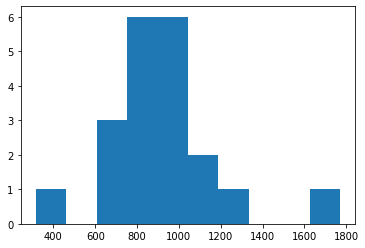

In [36]:
occurrences_counter = Occurrences_by_files(websites)

In [37]:
Statistics_by_file(occurrences_counter, websites)

Statistics at the file level 

Minimum:  316  -  0_processed.txt
Maximum:  1771  -  12_processed.txt
Standard deviation:  272.17
Mean:  927.85
Median:  910.0


In [38]:
occurrence_freq = Statistics_by_occurrences(occurrences)

Statistics at the occurrences level 

Minimum:  1
Maximum:  1892
Standard deviation:  32.78
Mean:  4.08
Median:  1.0


In [39]:
Most_frequent(occurrence_freq)

Ten most frequent occurrences 

the :  1892
of :  1191
to :  1169
and :  1005
a :  905
in :  772
that :  529
is :  420
for :  339
with :  309


In [40]:
Least_frequent(occurrence_freq)

Ten least frequent occurrences 

glance, :  1
boring :  1
stuff, :  1
merely :  1
convenient :  1
moisten :  1
understand. :  1
interacts :  1
enters :  1
99% :  1


### Travel

In [41]:
websites, occurrences = Read("travel")

Number of occurrences at the file level 

0_processed.txt :  835
10_processed.txt :  851
11_processed.txt :  743
12_processed.txt :  825
13_processed.txt :  808
14_processed.txt :  815
15_processed.txt :  830
16_processed.txt :  821
17_processed.txt :  807
1_processed.txt :  777
2_processed.txt :  887
3_processed.txt :  951
4_processed.txt :  874
5_processed.txt :  897
6_processed.txt :  994
7_processed.txt :  925
8_processed.txt :  883
9_processed.txt :  1317



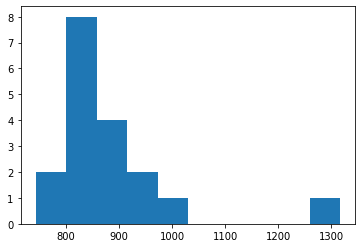

In [42]:
occurrences_counter = Occurrences_by_files(websites)

In [43]:
Statistics_by_file(occurrences_counter, websites)

Statistics at the file level 

Minimum:  743  -  11_processed.txt
Maximum:  1317  -  9_processed.txt
Standard deviation:  121.88
Mean:  880.0
Median:  843.0


In [44]:
occurrence_freq = Statistics_by_occurrences(occurrences)

Statistics at the occurrences level 

Minimum:  1
Maximum:  1968
Standard deviation:  29.91
Mean:  3.54
Median:  1.0


In [45]:
Most_frequent(occurrence_freq)

Ten most frequent occurrences 

the :  1968
of :  952
and :  945
to :  808
a :  781
in :  555
is :  304
that :  290
for :  263
on :  238


In [46]:
Least_frequent(occurrence_freq)

Ten least frequent occurrences 

2021 :  1
Farm, :  1
attraction :  1
Ottawa, :  1
Canada. :  1
Pibón :  1
(winter) :  1
Anishinaabe :  1
artist :  1
tremble :  1


### Worklife

In [47]:
websites, occurrences = Read("worklife")

Number of occurrences at the file level 

0_processed.txt :  231
10_processed.txt :  749
11_processed.txt :  654
12_processed.txt :  782
13_processed.txt :  738
14_processed.txt :  641
15_processed.txt :  718
16_processed.txt :  707
17_processed.txt :  724
1_processed.txt :  690
2_processed.txt :  801
3_processed.txt :  1186
4_processed.txt :  672
5_processed.txt :  600
6_processed.txt :  840
7_processed.txt :  844
8_processed.txt :  739
9_processed.txt :  914



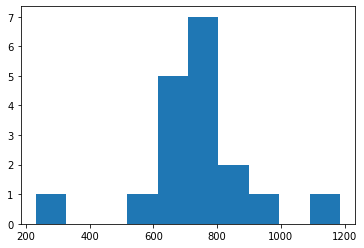

In [48]:
occurrences_counter = Occurrences_by_files(websites)

In [49]:
Statistics_by_file(occurrences_counter, websites)

Statistics at the file level 

Minimum:  231  -  0_processed.txt
Maximum:  1186  -  3_processed.txt
Standard deviation:  176.38
Mean:  735.0
Median:  731.0


In [50]:
occurrence_freq = Statistics_by_occurrences(occurrences)

Statistics at the occurrences level 

Minimum:  1
Maximum:  969
Standard deviation:  24.67
Mean:  4.04
Median:  1.0


In [51]:
Most_frequent(occurrence_freq)

Ten most frequent occurrences 

the :  969
to :  831
of :  685
a :  662
and :  652
in :  476
that :  340
for :  310
is :  237
with :  223


In [52]:
Least_frequent(occurrence_freq)

Ten least frequent occurrences 

smarter. :  1
better. :  1
deeper.Our :  1
shifting :  1
scale. :  1
rethinking :  1
value :  1
nine-to-five :  1
quaint :  1
relic :  1


## Creating model and evaluation

The next cell is used to create a dataset (csv file). <br>
**Don't run this part if you want to use a dataset we already have, because this step will overwrite the existing one.**

In [53]:
Make_csv("dataset.csv")

In [54]:
Make_model("dataset.csv")

Model accuracy:  56.0

[[ 4  0  0  0]
 [ 2 14  0  0]
 [11  5  0  0]
 [ 3  1  0 10]]

culture
Precision:  20.0
Recall:  100.0
F1 score:  33.33

future
Precision:  70.0
Recall:  87.5
F1 score:  77.78

travel
Precision:  nan
Recall:  0.0
F1 score:  nan

worklife
Precision:  100.0
Recall:  71.43
F1 score:  83.33

Macro precision:  nan
Micro precision:  56.0
Macro recall:  64.73
Micro recall:  56.0
Macro F1 score:  nan
Micro F1 score:  56.0


<ipython-input-22-04765982702c>:4: RuntimeWarning: invalid value encountered in long_scalars
  p = TP[i] / (TP[i] + FP[i])


# With stopwords and no normalization

In [55]:
for section in sections:
    Processing_folder(section, True, False)

## Descriptive statistics

### Culture

In [56]:
websites, occurrences = Read("culture")

Number of occurrences at the file level 

0_processed.txt :  854
1_processed.txt :  972
2_processed.txt :  920
3_processed.txt :  434
4_processed.txt :  934
5_processed.txt :  924
6_processed.txt :  818
7_processed.txt :  859
8_processed.txt :  988
9_processed.txt :  640



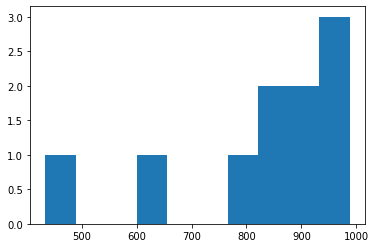

In [57]:
occurrences_counter = Occurrences_by_files(websites)

In [58]:
Statistics_by_file(occurrences_counter, websites)

Statistics at the file level 

Minimum:  434  -  3_processed.txt
Maximum:  988  -  8_processed.txt
Standard deviation:  163.45
Mean:  834.3
Median:  889.5


In [59]:
occurrence_freq = Statistics_by_occurrences(occurrences)

Statistics at the occurrences level 

Minimum:  1
Maximum:  119
Standard deviation:  3.33
Mean:  1.89
Median:  1.0


In [60]:
Most_frequent(occurrence_freq)

Ten most frequent occurrences 

The :  119
– :  102
I :  55
like :  49
BBC :  41
first :  38
music :  37
one :  36
film :  35
also :  31


In [61]:
Least_frequent(occurrence_freq)

Ten least frequent occurrences 

"How :  1
lived, :  1
death!" :  1
Janet :  1
Flanner :  1
1967. :  1
century :  1
later, :  1
week :  1
sees :  1


### Future

In [62]:
websites, occurrences = Read("future")

Number of occurrences at the file level 

0_processed.txt :  273
10_processed.txt :  927
11_processed.txt :  746
12_processed.txt :  1665
13_processed.txt :  801
14_processed.txt :  843
15_processed.txt :  625
16_processed.txt :  675
17_processed.txt :  956
18_processed.txt :  647
19_processed.txt :  989
1_processed.txt :  695
2_processed.txt :  919
3_processed.txt :  696
4_processed.txt :  890
5_processed.txt :  953
6_processed.txt :  1158
7_processed.txt :  765
8_processed.txt :  656
9_processed.txt :  936



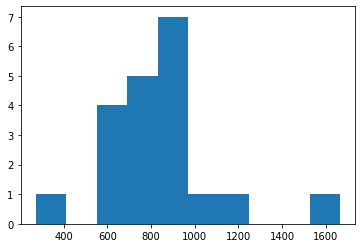

In [63]:
occurrences_counter = Occurrences_by_files(websites)

In [64]:
Statistics_by_file(occurrences_counter, websites)

Statistics at the file level 

Minimum:  273  -  0_processed.txt
Maximum:  1665  -  12_processed.txt
Standard deviation:  262.63
Mean:  840.75
Median:  822.0


In [65]:
occurrence_freq = Statistics_by_occurrences(occurrences)

Statistics at the occurrences level 

Minimum:  1
Maximum:  248
Standard deviation:  5.9
Mean:  2.5
Median:  1.0


In [66]:
Most_frequent(occurrence_freq)

Ten most frequent occurrences 

– :  248
says :  186
also :  125
people :  116
one :  110
The :  106
may :  87
many :  82
could :  80
children :  79


In [67]:
Least_frequent(occurrence_freq)

Ten least frequent occurrences 

glance, :  1
boring :  1
stuff, :  1
merely :  1
convenient :  1
moisten :  1
understand. :  1
interacts :  1
enters :  1
99% :  1


### Travel

In [68]:
websites, occurrences = Read("travel")

Number of occurrences at the file level 

0_processed.txt :  744
10_processed.txt :  774
11_processed.txt :  673
12_processed.txt :  736
13_processed.txt :  725
14_processed.txt :  735
15_processed.txt :  741
16_processed.txt :  742
17_processed.txt :  720
1_processed.txt :  690
2_processed.txt :  800
3_processed.txt :  860
4_processed.txt :  793
5_processed.txt :  813
6_processed.txt :  907
7_processed.txt :  835
8_processed.txt :  795
9_processed.txt :  1221



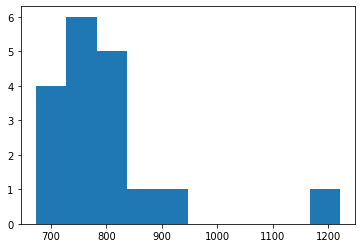

In [69]:
occurrences_counter = Occurrences_by_files(websites)

In [70]:
Statistics_by_file(occurrences_counter, websites)

Statistics at the file level 

Minimum:  673  -  11_processed.txt
Maximum:  1221  -  9_processed.txt
Standard deviation:  118.43
Mean:  794.67
Median:  759.0


In [71]:
occurrence_freq = Statistics_by_occurrences(occurrences)

Statistics at the occurrences level 

Minimum:  1
Maximum:  158
Standard deviation:  4.32
Mean:  2.24
Median:  1.0


In [72]:
Most_frequent(occurrence_freq)

Ten most frequent occurrences 

I :  158
The :  137
(Credit: :  99
– :  81
like :  68
one :  61
us :  53
said :  52
people :  50
also :  46


In [73]:
Least_frequent(occurrence_freq)

Ten least frequent occurrences 

2021 :  1
Farm, :  1
attraction :  1
Ottawa, :  1
Canada. :  1
Pibón :  1
(winter) :  1
Anishinaabe :  1
artist :  1
tremble :  1


### Worklife

In [74]:
websites, occurrences = Read("worklife")

Number of occurrences at the file level 

0_processed.txt :  190
10_processed.txt :  660
11_processed.txt :  579
12_processed.txt :  694
13_processed.txt :  656
14_processed.txt :  560
15_processed.txt :  645
16_processed.txt :  627
17_processed.txt :  644
1_processed.txt :  620
2_processed.txt :  721
3_processed.txt :  1075
4_processed.txt :  591
5_processed.txt :  522
6_processed.txt :  760
7_processed.txt :  748
8_processed.txt :  660
9_processed.txt :  824



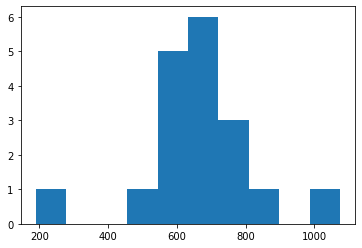

In [75]:
occurrences_counter = Occurrences_by_files(websites)

In [76]:
Statistics_by_file(occurrences_counter, websites)

Statistics at the file level 

Minimum:  190  -  0_processed.txt
Maximum:  1075  -  3_processed.txt
Standard deviation:  164.25
Mean:  654.22
Median:  650.5


In [77]:
occurrence_freq = Statistics_by_occurrences(occurrences)

Statistics at the occurrences level 

Minimum:  1
Maximum:  199
Standard deviation:  5.7
Mean:  2.52
Median:  1.0


In [78]:
Most_frequent(occurrence_freq)

Ten most frequent occurrences 

– :  199
people :  147
says :  144
I :  86
may :  83
like :  81
many :  72
also :  66
one :  63
workers :  60


In [79]:
Least_frequent(occurrence_freq)

Ten least frequent occurrences 

smarter. :  1
better. :  1
deeper.Our :  1
shifting :  1
scale. :  1
rethinking :  1
value :  1
nine-to-five :  1
quaint :  1
relic :  1


## Creating model and evaluation

The next cell is used to create a dataset (csv file). **Don't run this part if you want to use a dataset we already have, because this step will overwrite the existing one.**

In [80]:
Make_csv("dataset_stopwrds.csv")

In [81]:
Make_model("dataset_stopwrds.csv")

Model accuracy:  66.0

[[ 4  0  0  0]
 [ 1 15  0  0]
 [ 6 10  0  0]
 [ 0  0  0 14]]

culture
Precision:  36.36
Recall:  100.0
F1 score:  53.33

future
Precision:  60.0
Recall:  93.75
F1 score:  73.17

travel
Precision:  nan
Recall:  0.0
F1 score:  nan

worklife
Precision:  100.0
Recall:  100.0
F1 score:  100.0

Macro precision:  nan
Micro precision:  66.0
Macro recall:  73.44
Micro recall:  66.0
Macro F1 score:  nan
Micro F1 score:  66.0


<ipython-input-22-04765982702c>:4: RuntimeWarning: invalid value encountered in long_scalars
  p = TP[i] / (TP[i] + FP[i])


# No stopwords and with normalization

In [82]:
for section in sections:
    Processing_folder(section, False, True)

## Descriptive statistics

### Culture

In [83]:
websites, occurrences = Read("culture")

Number of occurrences at the file level 

0_processed.txt :  720
1_processed.txt :  889
2_processed.txt :  800
3_processed.txt :  431
4_processed.txt :  776
5_processed.txt :  755
6_processed.txt :  695
7_processed.txt :  760
8_processed.txt :  850
9_processed.txt :  609



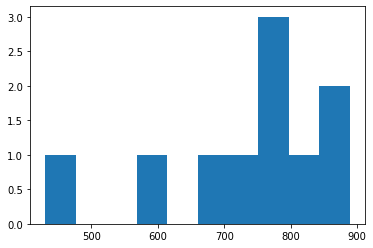

In [84]:
occurrences_counter = Occurrences_by_files(websites)

In [85]:
Statistics_by_file(occurrences_counter, websites)

Statistics at the file level 

Minimum:  431  -  3_processed.txt
Maximum:  889  -  1_processed.txt
Standard deviation:  123.92
Mean:  728.5
Median:  757.5


In [86]:
occurrence_freq = Statistics_by_occurrences(occurrences)

Statistics at the occurrences level 

Minimum:  1
Maximum:  984
Standard deviation:  26.27
Mean:  4.69
Median:  1.0


In [87]:
Most_frequent(occurrence_freq)

Ten most frequent occurrences 

the :  984
of :  585
and :  574
a :  555
to :  433
in :  382
is :  216
that :  196
as :  182
for :  169


In [88]:
Least_frequent(occurrence_freq)

Ten least frequent occurrences 

janet :  1
flanner :  1
1967 :  1
150th :  1
occas :  1
1920 :  1
1926 :  1
writersmor :  1
reward :  1
'lost :  1


### Future

In [89]:
websites, occurrences = Read("future")

Number of occurrences at the file level 

0_processed.txt :  276
10_processed.txt :  767
11_processed.txt :  651
12_processed.txt :  1331
13_processed.txt :  680
14_processed.txt :  714
15_processed.txt :  557
16_processed.txt :  604
17_processed.txt :  814
18_processed.txt :  579
19_processed.txt :  819
1_processed.txt :  603
2_processed.txt :  763
3_processed.txt :  606
4_processed.txt :  730
5_processed.txt :  795
6_processed.txt :  915
7_processed.txt :  640
8_processed.txt :  582
9_processed.txt :  784



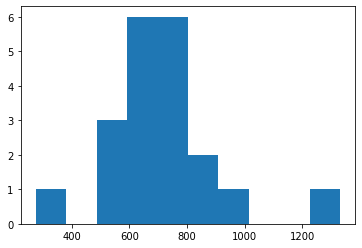

In [90]:
occurrences_counter = Occurrences_by_files(websites)

In [91]:
Statistics_by_file(occurrences_counter, websites)

Statistics at the file level 

Minimum:  276  -  0_processed.txt
Maximum:  1331  -  12_processed.txt
Standard deviation:  194.63
Mean:  710.5
Median:  697.0


In [92]:
occurrence_freq = Statistics_by_occurrences(occurrences)

Statistics at the occurrences level 

Minimum:  1
Maximum:  2059
Standard deviation:  46.56
Mean:  7.23
Median:  1.0


In [93]:
Most_frequent(occurrence_freq)

Ten most frequent occurrences 

the :  2059
of :  1197
to :  1181
and :  1056
a :  955
in :  861
that :  554
is :  426
for :  364
it :  358


In [94]:
Least_frequent(occurrence_freq)

Ten least frequent occurrences 

bore :  1
stuff :  1
conveni :  1
moisten :  1
99 :  1
biologist :  1
guy :  1
king' :  1
londonscientist :  1
saliva' :  1


### Travel

In [95]:
websites, occurrences = Read("travel")

Number of occurrences at the file level 

0_processed.txt :  638
10_processed.txt :  696
11_processed.txt :  593
12_processed.txt :  647
13_processed.txt :  633
14_processed.txt :  656
15_processed.txt :  686
16_processed.txt :  647
17_processed.txt :  642
1_processed.txt :  641
2_processed.txt :  681
3_processed.txt :  765
4_processed.txt :  704
5_processed.txt :  711
6_processed.txt :  792
7_processed.txt :  744
8_processed.txt :  660
9_processed.txt :  1017



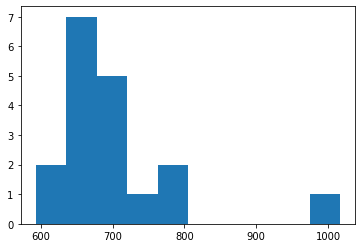

In [96]:
occurrences_counter = Occurrences_by_files(websites)

In [97]:
Statistics_by_file(occurrences_counter, websites)

Statistics at the file level 

Minimum:  593  -  11_processed.txt
Maximum:  1017  -  9_processed.txt
Standard deviation:  91.74
Mean:  697.39
Median:  670.5


In [98]:
occurrence_freq = Statistics_by_occurrences(occurrences)

Statistics at the occurrences level 

Minimum:  1
Maximum:  2162
Standard deviation:  41.45
Mean:  5.9
Median:  1.0


In [99]:
Most_frequent(occurrence_freq)

Ten most frequent occurrences 

the :  2162
and :  972
of :  955
a :  833
to :  820
in :  614
is :  310
that :  303
it :  282
for :  274


In [100]:
Least_frequent(occurrence_freq)

Ten least frequent occurrences 

pibón :  1
anishinaab :  1
trembl :  1
exuber :  1
justdepart :  1
pow :  1
wow :  1
woodlandsstyl :  1
lifelong :  1
canadasnow :  1


### Worklife

In [101]:
websites, occurrences = Read("worklife")

Number of occurrences at the file level 

0_processed.txt :  203
10_processed.txt :  562
11_processed.txt :  542
12_processed.txt :  623
13_processed.txt :  588
14_processed.txt :  527
15_processed.txt :  582
16_processed.txt :  558
17_processed.txt :  584
1_processed.txt :  548
2_processed.txt :  671
3_processed.txt :  841
4_processed.txt :  554
5_processed.txt :  494
6_processed.txt :  683
7_processed.txt :  677
8_processed.txt :  582
9_processed.txt :  741



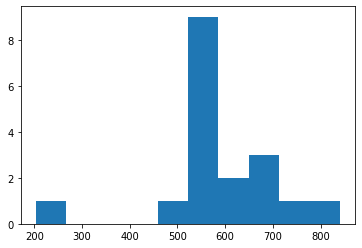

In [102]:
occurrences_counter = Occurrences_by_files(websites)

In [103]:
Statistics_by_file(occurrences_counter, websites)

Statistics at the file level 

Minimum:  203  -  0_processed.txt
Maximum:  841  -  3_processed.txt
Standard deviation:  124.67
Mean:  586.67
Median:  582.0


In [104]:
occurrence_freq = Statistics_by_occurrences(occurrences)

Statistics at the occurrences level 

Minimum:  1
Maximum:  1024
Standard deviation:  33.59
Mean:  6.69
Median:  1.0


In [105]:
Most_frequent(occurrence_freq)

Ten most frequent occurrences 

the :  1024
to :  845
of :  690
and :  690
a :  669
in :  523
that :  360
for :  327
be :  254
is :  244


In [106]:
Least_frequent(occurrence_freq)

Ten least frequent occurrences 

deeperour :  1
ninetof :  1
quaint :  1
relic :  1
bleed :  1
uncertainti :  1
understandto :  1
lifeour :  1
mission :  1
yourself :  1


## Creating model and evaluation

The next cell is used to create a dataset (csv file). **Don't run this part if you want to use a dataset we already have, because this step will overwrite the existing one.**

In [107]:
Make_csv("dataset_norm.csv")

In [108]:
Make_model("dataset_norm.csv")

Model accuracy:  60.0

[[ 4  0  0  0]
 [ 1 15  0  0]
 [ 9  7  0  0]
 [ 1  2  0 11]]

culture
Precision:  26.67
Recall:  100.0
F1 score:  42.11

future
Precision:  62.5
Recall:  93.75
F1 score:  75.0

travel
Precision:  nan
Recall:  0.0
F1 score:  nan

worklife
Precision:  100.0
Recall:  78.57
F1 score:  88.0

Macro precision:  nan
Micro precision:  60.0
Macro recall:  68.08
Micro recall:  60.0
Macro F1 score:  nan
Micro F1 score:  60.0


<ipython-input-22-04765982702c>:4: RuntimeWarning: invalid value encountered in long_scalars
  p = TP[i] / (TP[i] + FP[i])


# With stopwords and with normalization

In [109]:
for section in sections:
    Processing_folder(section, True, True)

## Descriptive statistics

### Culture

In [110]:
websites, occurrences = Read("culture")

Number of occurrences at the file level 

0_processed.txt :  649
1_processed.txt :  808
2_processed.txt :  719
3_processed.txt :  368
4_processed.txt :  686
5_processed.txt :  675
6_processed.txt :  623
7_processed.txt :  677
8_processed.txt :  768
9_processed.txt :  533



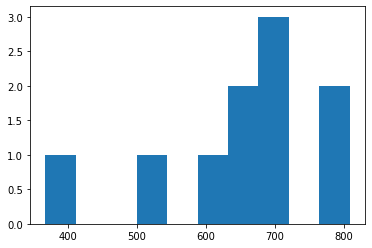

In [111]:
occurrences_counter = Occurrences_by_files(websites)

In [112]:
Statistics_by_file(occurrences_counter, websites)

Statistics at the file level 

Minimum:  368  -  3_processed.txt
Maximum:  808  -  1_processed.txt
Standard deviation:  118.42
Mean:  650.6
Median:  676.0


In [113]:
occurrence_freq = Statistics_by_occurrences(occurrences)

Statistics at the occurrences level 

Minimum:  1
Maximum:  119
Standard deviation:  5.72
Mean:  2.9
Median:  1.0


In [114]:
Most_frequent(occurrence_freq)

Ten most frequent occurrences 

wa :  119
– :  104
hi :  97
thi :  92
like :  69
film :  63
ha :  62
cultur :  57
work :  55
us :  53


In [115]:
Least_frequent(occurrence_freq)

Ten least frequent occurrences 

janet :  1
flanner :  1
1967 :  1
150th :  1
occas :  1
1920 :  1
1926 :  1
writersmor :  1
reward :  1
'lost :  1


### Future

In [116]:
websites, occurrences = Read("future")

Number of occurrences at the file level 

0_processed.txt :  228
10_processed.txt :  696
11_processed.txt :  576
12_processed.txt :  1235
13_processed.txt :  608
14_processed.txt :  631
15_processed.txt :  485
16_processed.txt :  526
17_processed.txt :  730
18_processed.txt :  502
19_processed.txt :  742
1_processed.txt :  527
2_processed.txt :  677
3_processed.txt :  530
4_processed.txt :  648
5_processed.txt :  716
6_processed.txt :  822
7_processed.txt :  554
8_processed.txt :  508
9_processed.txt :  698



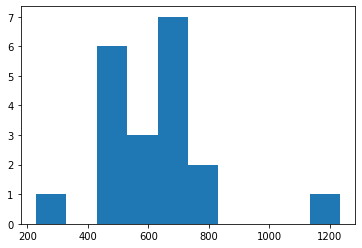

In [117]:
occurrences_counter = Occurrences_by_files(websites)

In [118]:
Statistics_by_file(occurrences_counter, websites)

Statistics at the file level 

Minimum:  228  -  0_processed.txt
Maximum:  1235  -  12_processed.txt
Standard deviation:  186.92
Mean:  631.95
Median:  619.5


In [119]:
occurrence_freq = Statistics_by_occurrences(occurrences)

Statistics at the occurrences level 

Minimum:  1
Maximum:  257
Standard deviation:  10.79
Mean:  4.37
Median:  1.0


In [120]:
Most_frequent(occurrence_freq)

Ten most frequent occurrences 

say :  257
– :  248
wa :  224
thi :  202
one :  140
peopl :  132
also :  126
ha :  124
like :  116
hi :  104


In [121]:
Least_frequent(occurrence_freq)

Ten least frequent occurrences 

bore :  1
stuff :  1
conveni :  1
moisten :  1
99 :  1
biologist :  1
guy :  1
king' :  1
londonscientist :  1
saliva' :  1


### Travel

In [122]:
websites, occurrences = Read("travel")

Number of occurrences at the file level 

0_processed.txt :  557
10_processed.txt :  621
11_processed.txt :  530
12_processed.txt :  567
13_processed.txt :  557
14_processed.txt :  581
15_processed.txt :  605
16_processed.txt :  577
17_processed.txt :  563
1_processed.txt :  561
2_processed.txt :  598
3_processed.txt :  684
4_processed.txt :  630
5_processed.txt :  635
6_processed.txt :  710
7_processed.txt :  662
8_processed.txt :  581
9_processed.txt :  928



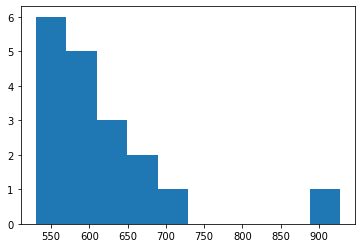

In [123]:
occurrences_counter = Occurrences_by_files(websites)

In [124]:
Statistics_by_file(occurrences_counter, websites)

Statistics at the file level 

Minimum:  530  -  11_processed.txt
Maximum:  928  -  9_processed.txt
Standard deviation:  88.29
Mean:  619.28
Median:  589.5


In [125]:
occurrence_freq = Statistics_by_occurrences(occurrences)

Statistics at the occurrences level 

Minimum:  1
Maximum:  216
Standard deviation:  7.6
Mean:  3.67
Median:  1.0


In [126]:
Most_frequent(occurrence_freq)

Ten most frequent occurrences 

wa :  216
thi :  126
like :  117
credit :  99
said :  97
one :  82
ha :  82
– :  81
us :  76
travel :  76


In [127]:
Least_frequent(occurrence_freq)

Ten least frequent occurrences 

pibón :  1
anishinaab :  1
trembl :  1
exuber :  1
justdepart :  1
pow :  1
wow :  1
woodlandsstyl :  1
lifelong :  1
canadasnow :  1


### Worklife

In [128]:
websites, occurrences = Read("worklife")

Number of occurrences at the file level 

0_processed.txt :  161
10_processed.txt :  485
11_processed.txt :  477
12_processed.txt :  547
13_processed.txt :  513
14_processed.txt :  457
15_processed.txt :  513
16_processed.txt :  490
17_processed.txt :  514
1_processed.txt :  483
2_processed.txt :  602
3_processed.txt :  749
4_processed.txt :  482
5_processed.txt :  419
6_processed.txt :  617
7_processed.txt :  591
8_processed.txt :  506
9_processed.txt :  656



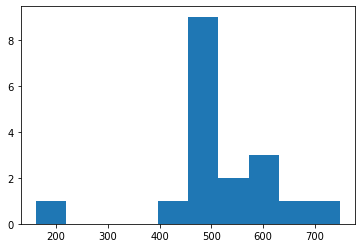

In [129]:
occurrences_counter = Occurrences_by_files(websites)

In [130]:
Statistics_by_file(occurrences_counter, websites)

Statistics at the file level 

Minimum:  161  -  0_processed.txt
Maximum:  749  -  3_processed.txt
Standard deviation:  116.06
Mean:  514.56
Median:  509.5


In [131]:
occurrence_freq = Statistics_by_occurrences(occurrences)

Statistics at the occurrences level 

Minimum:  1
Maximum:  240
Standard deviation:  9.86
Mean:  4.12
Median:  1.0


In [132]:
Most_frequent(occurrence_freq)

Ten most frequent occurrences 

say :  240
– :  199
peopl :  166
like :  118
relationship :  112
work :  112
wa :  108
thi :  104
worker :  92
ha :  90


In [133]:
Least_frequent(occurrence_freq)

Ten least frequent occurrences 

deeperour :  1
ninetof :  1
quaint :  1
relic :  1
bleed :  1
uncertainti :  1
understandto :  1
lifeour :  1
mission :  1
stifl :  1


## Creating model and evaluation

The next cell is used to create a dataset (csv file). **Don't run this part if you want to use a dataset we already have, because this step will overwrite the existing one.**

In [134]:
Make_csv("dataset_stopwrds_norm.csv")

In [135]:
Make_model("dataset_stopwrds_norm.csv")

Model accuracy:  66.0

[[ 4  0  0  0]
 [ 1 14  1  0]
 [ 5 10  1  0]
 [ 0  0  0 14]]

culture
Precision:  40.0
Recall:  100.0
F1 score:  57.14

future
Precision:  58.33
Recall:  87.5
F1 score:  70.0

travel
Precision:  50.0
Recall:  6.25
F1 score:  11.11

worklife
Precision:  100.0
Recall:  100.0
F1 score:  100.0

Macro precision:  62.08
Micro precision:  66.0
Macro recall:  73.44
Micro recall:  66.0
Macro F1 score:  67.28
Micro F1 score:  66.0
